In [229]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
batting_2024 = pd.read_csv("/Users/benboda/Downloads/GitHub/Econometrics_Term_Paper/Yearly_Data/2024batting.csv")
batting_2024 = batting_2024.add_suffix("_bat")
pitching_2024 = pd.read_csv("/Users/benboda/Downloads/GitHub/Econometrics_Term_Paper/Yearly_Data/2024pitching.csv")
pitching_2024 = pitching_2024.add_suffix("_pitch")
fielding_2024 = pd.read_csv("/Users/benboda/Downloads/GitHub/Econometrics_Term_Paper/Yearly_Data/2024fielding.csv")
fielding_2024 = fielding_2024.add_suffix("_field")
data_2024 = pd.merge(pd.merge(batting_2024, pitching_2024, left_on="Tm_bat", right_on="Tm_pitch"), fielding_2024, left_on="Tm_pitch", right_on="Tm_field")
data_2024.drop(["Tm_pitch", "Tm_field"], axis=1, inplace=True)
data_2024 = data_2024.iloc[0:30]
win_totals = pd.read_csv("/Users/benboda/Downloads/GitHub/Econometrics_Term_Paper/Yearly_Data/win_totals.csv")
# print(data_2024.columns)
# Ideas for most important variables:
#   Whip, pitcher strikeouts, strikeout to walk ratio, fielding percentage, defensive efficiency, home runs or XBH, on base percentage, maybe stolen bases, hitter strikeouts to measure overtime, maybe LOB, OPS+

Index(['Tm_bat', '#Bat_bat', 'BatAge_bat', 'R/G_bat', 'G_bat', 'PA_bat',
       'AB_bat', 'R_bat', 'H_bat', '2B_bat', '3B_bat', 'HR_bat', 'RBI_bat',
       'SB_bat', 'CS_bat', 'BB_bat', 'SO_bat', 'BA_bat', 'OBP_bat', 'SLG_bat',
       'OPS_bat', 'OPS+_bat', 'TB_bat', 'GDP_bat', 'HBP_bat', 'SH_bat',
       'SF_bat', 'IBB_bat', 'LOB_bat', '#P_pitch', 'PAge_pitch', 'RA/G_pitch',
       'W_pitch', 'L_pitch', 'W-L%_pitch', 'ERA_pitch', 'G_pitch', 'GS_pitch',
       'GF_pitch', 'CG_pitch', 'tSho_pitch', 'cSho_pitch', 'SV_pitch',
       'IP_pitch', 'H_pitch', 'R_pitch', 'ER_pitch', 'HR_pitch', 'BB_pitch',
       'IBB_pitch', 'SO_pitch', 'HBP_pitch', 'BK_pitch', 'WP_pitch',
       'BF_pitch', 'ERA+_pitch', 'FIP_pitch', 'WHIP_pitch', 'H9_pitch',
       'HR9_pitch', 'BB9_pitch', 'SO9_pitch', 'SO/W_pitch', 'LOB_pitch',
       '#Fld_field', 'RA/G_field', 'DefEff_field', 'G_field', 'GS_field',
       'CG_field', 'Inn_field', 'Ch_field', 'PO_field', 'A_field', 'E_field',
       'DP_field', 'Fld%_fie

In [231]:
initials_dict = {"ARI": "Arizona Diamondbacks", "ATL": "Atlanta Braves", "BAL": "Baltimore Orioles", "BOS": "Boston Red Sox", "CHC": "Chicago Cubs", "CHW": "Chicago White Sox", "CIN": "Cincinnati Reds", "CLE": ["Cleveland Guardians", "Cleveland Indians"], "COL": "Colorado Rockies", "DET": "Detroit Tigers", "HOU": "Houston Astros", "KCR": "Kansas City Royals", "LAA": ["Los Angeles Angels", "Los Angeles Angels of Aneheim"], "LAD": "Los Angeles Dodgers", "MIA": "Miami Marlins", "MIL": "Milwaukee Brewers", "MIN": "Minnesota Twins", "NYM": "New York Mets", "NYY": "New York Yankees", "OAK": "Oakland Athletics", "PHI": "Philadelphia Phillies", "PIT": "Pittsburgh Pirates", "SDP": "San Diego Padres", "SFG": "San Francisco Giants", "SEA": "Seattle Mariners", "STL": "St. Louis Cardinals", "TBR": "Tampa Bay Rays", "TEX": "Texas Rangers", "TOR": "Toronto Blue Jays", "WSN": "Washington Nationals"}

In [232]:
win_totals = win_totals.melt(
    id_vars=["Year", "G"],
    var_name="Team", 
    value_name="Wins"
    )
win_totals.dropna(inplace=True)
win_totals.reset_index(drop=True, inplace=True)
win_totals.drop("G", axis=1, inplace=True)
win_totals2024 = win_totals[(win_totals["Year"] == 2024)].copy()
win_totals2024.reset_index(drop=True, inplace=True)

In [233]:
invert_dict = {team: abbr for abbr, teams in initials_dict.items() for team in (teams if isinstance(teams, list) else [teams])}
data_2024["Team Abbreviation"] = data_2024["Tm_bat"].map(invert_dict)
data_2024 = data_2024.merge(win_totals2024, left_on="Team Abbreviation", right_on="Team", how="left", suffixes=("", "_wintotals"))
data_2024.drop(["Team Abbreviation", "Year"], axis=1, inplace=True)
data_2024.rename(columns={"Team": "Abbreviation", "Wins": "Wins"}, inplace=True)
data_2024.insert(1, "Abbreviation", data_2024.pop("Abbreviation"))
data_2024.insert(2, "Wins", data_2024.pop("Wins"))
data_2024["Team"] = data_2024["Tm_bat"] + " " + "(" + data_2024["Abbreviation"] + ")"
data_2024.drop(["Tm_bat", "Abbreviation"], axis=1, inplace=True)
data_2024.insert(0, "Team", data_2024.pop("Team"))
data_2024.set_index("Team", inplace=True)
data_2024.dropna(inplace=True)
data_2024["XBH_bat"] = data_2024["2B_bat"] + data_2024["3B_bat"] + data_2024["HR_bat"]
data_2024.insert(12, "XBH_bat", data_2024.pop("XBH_bat"))

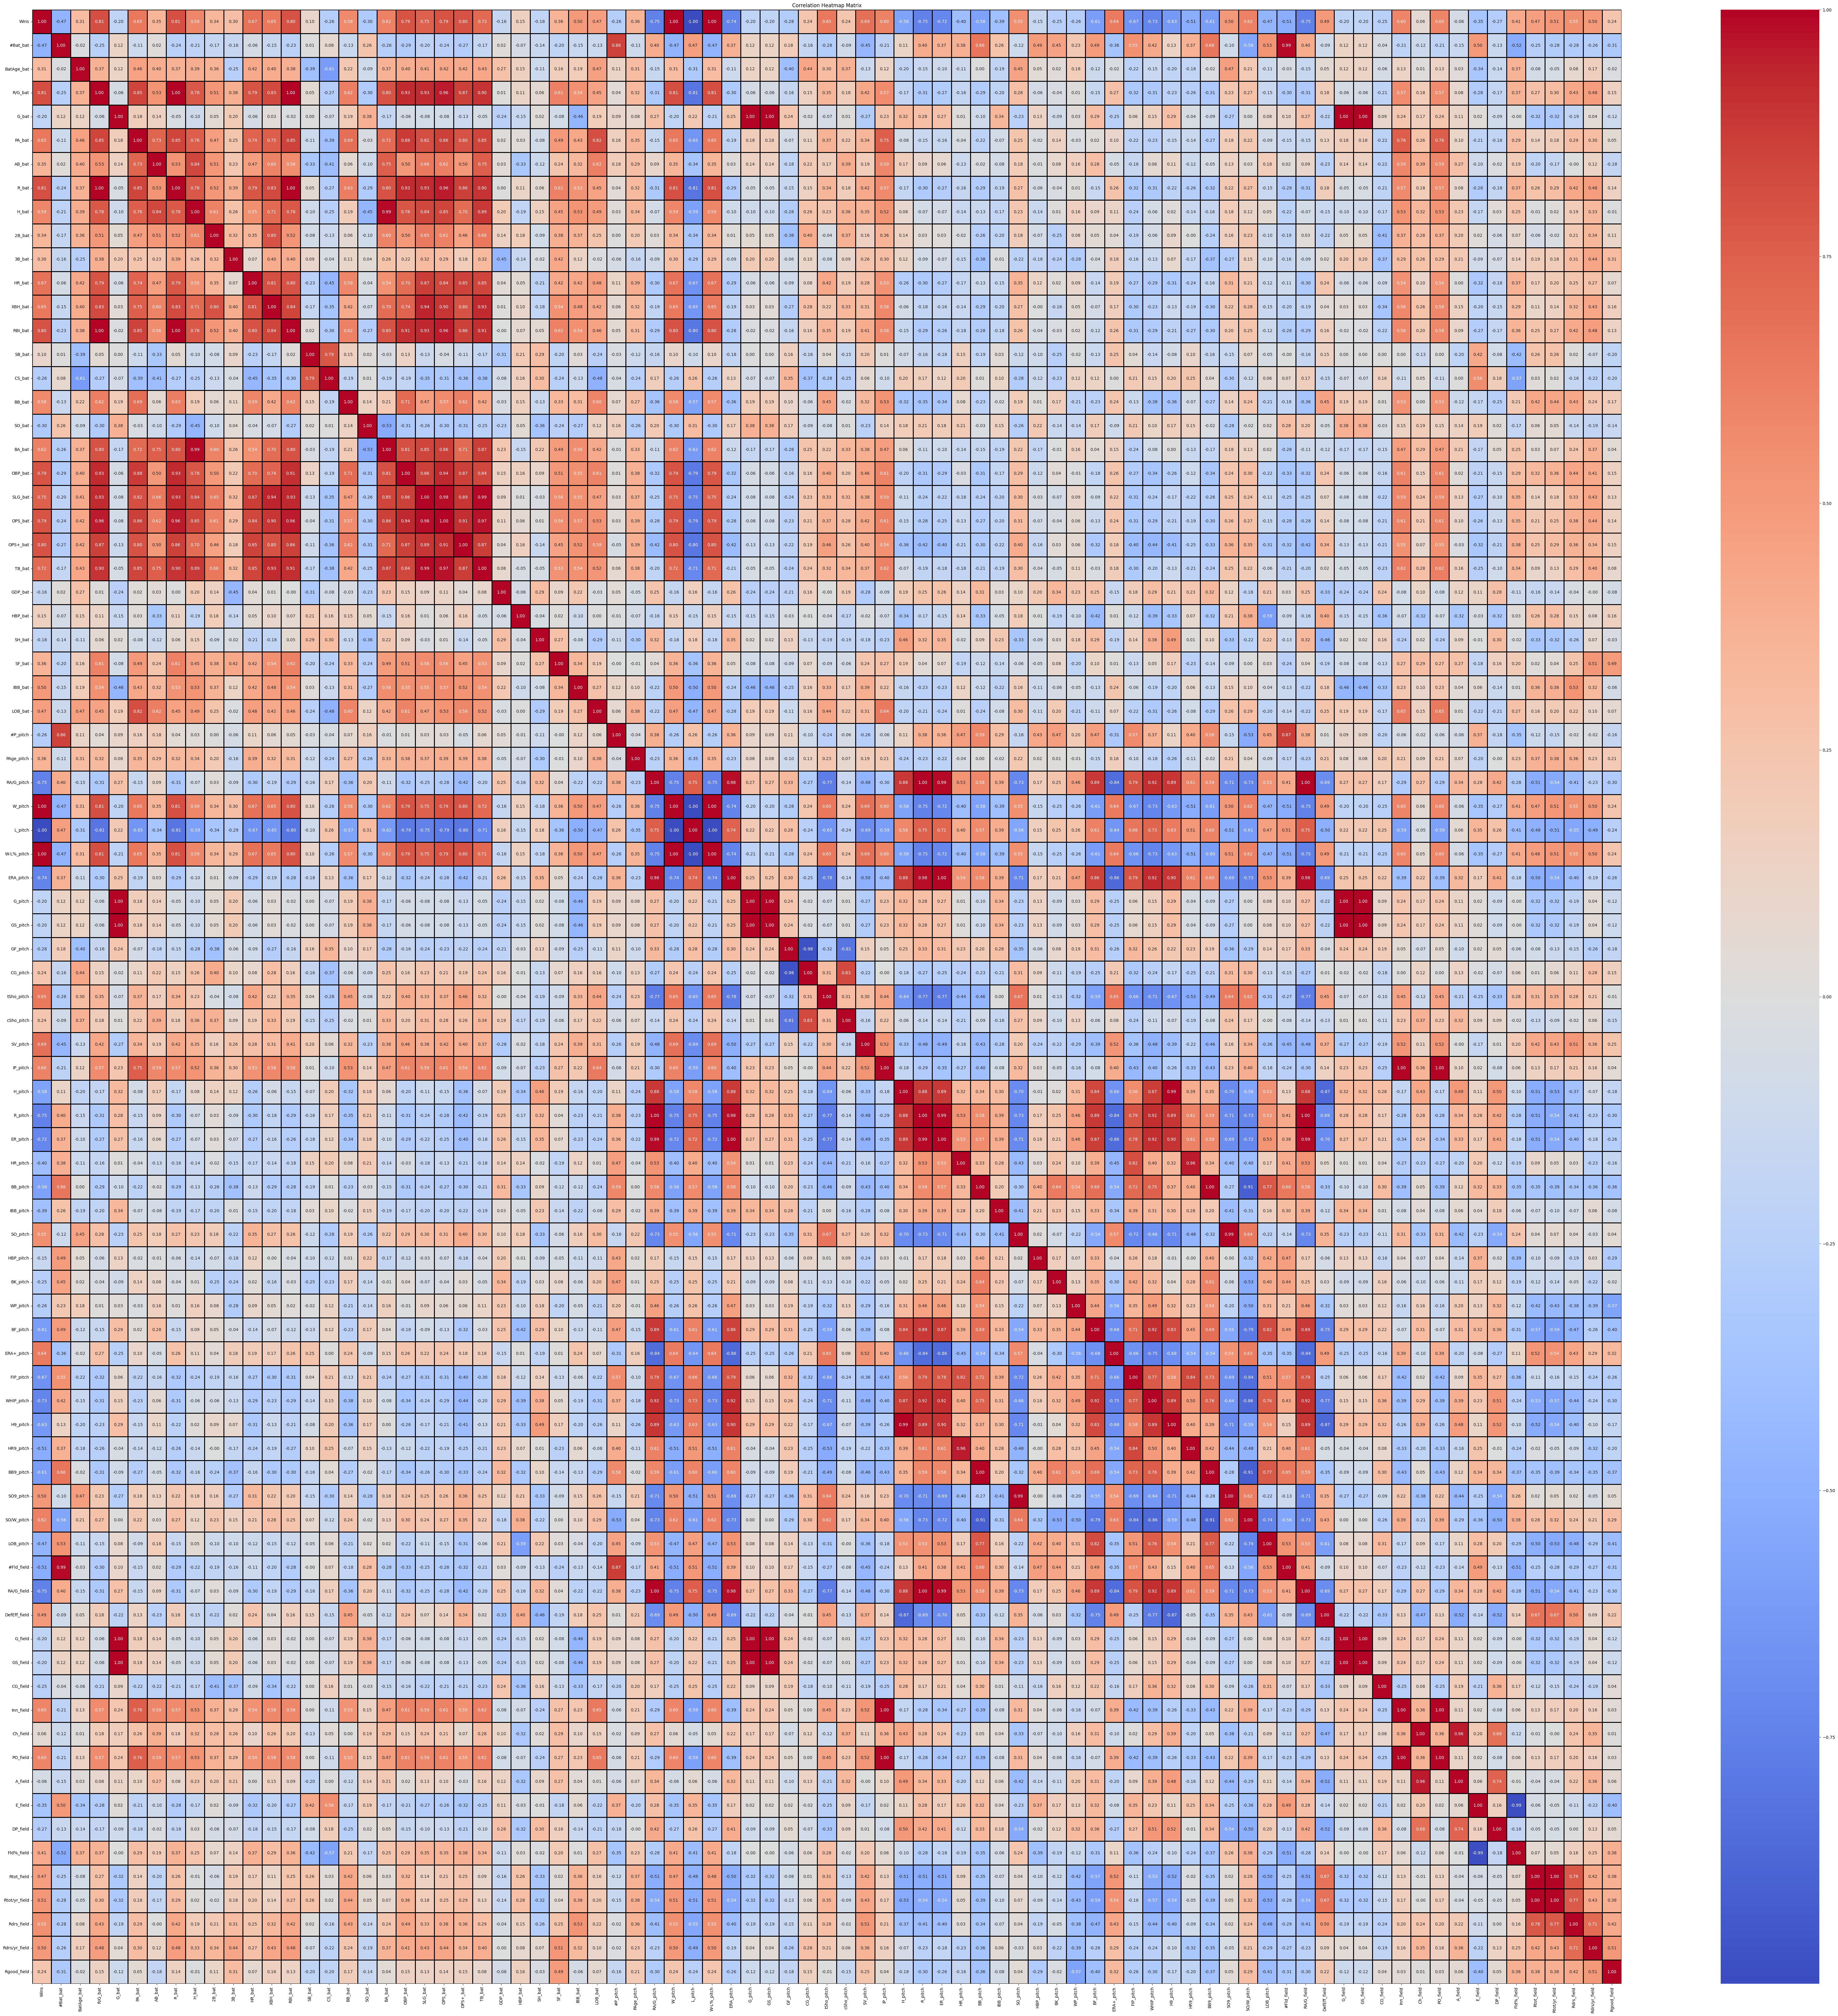

In [236]:
corr_matrix = data_2024.corr()
plt.figure(figsize=(85, 85))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=1, linecolor="black")
plt.title("Correlation Heatmap Matrix")
plt.show()

In [235]:
X = data_2024[["XBH_bat", "SO_bat", "SB_bat", "LOB_bat"]]
Y = data_2024["Wins"]
model = sm.OLS(Y, sm.add_constant(X)).fit()
print(model.summary())
n = len(data_2024)
k = X.shape[1]
df = n - k - 1
alpha = 0.05
critical_t = stats.t.ppf(1 - alpha/2, df)
print(f"Critical t-stat: {critical_t}")

                            OLS Regression Results                            
Dep. Variable:                   Wins   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     10.70
Date:                Fri, 29 Nov 2024   Prob (F-statistic):           3.42e-05
Time:                        14:43:27   Log-Likelihood:                -102.79
No. Observations:                  30   AIC:                             215.6
Df Residuals:                      25   BIC:                             222.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -56.4055     37.723     -1.495      0.1